# Overlay graphs
This notebook contains the code for generating graphs of central canal images with fluobeads overlayed with their respective velocities calculated with kymographs. Most of the code isn't optimized for practicality and performance, if I have some time I will clean it up.

In [11]:
import sys
sys.path.append('cerebroflow')
import kymo as ky
import PySimpleGUI as sg
import matplotlib.pyplot as plt
import matplotlib.image
import numpy as np
import matplotlib.lines as mlines
import os

# Import raw time lapse

path = "Z:\\qfavey\\01_Experiments\\01_CSF_FLOW\\IMAGING_TESTS\\Successful_Images\\WT_B\\Somites 5-10\\RAW\\WT_somites_5-10_B05_cropped.tif"
path = os.path.normpath(path)
print("Image path: ",path)
# pixel size: 0.16250000000000003 (olympus 40x) or 0.189 (pub)
pixel_size = 0.16250000000000003
frame_time = 0.159
exp1 = ky.Kymo(path, pixel_size=pixel_size, frame_time=frame_time)
exp1.generate_kymo(threshold=0.5,dash=False)

Image path:  Z:\qfavey\01_Experiments\01_CSF_FLOW\IMAGING_TESTS\Successful_Images\WT_B\Somites 5-10\RAW\WT_somites_5-10_B05_cropped.tif
----- Input image: WT_somites_5-10_B05_cropped.tif

Loading from previous processing!
Analyzing WT_somites_5-10_B05_cropped.tif:
threshold: 	0.5 
method: 	Quantile 
filter size: 	None
Detecting and processing blobs for d-v positions: 100.0%
Detected 534 traces.
Done! 




(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

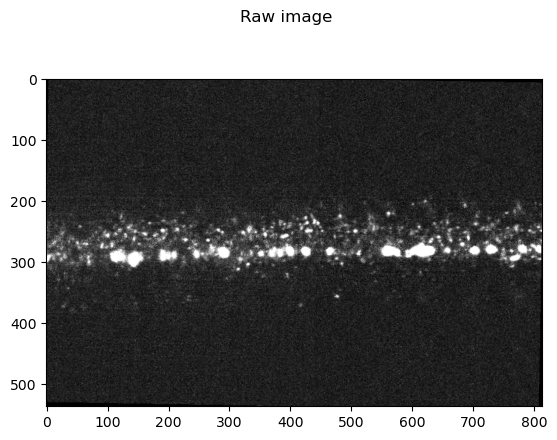

In [12]:
import matplotlib.pyplot as plt

# Assuming exp1 is an object containing image data
raw_image = exp1.images.copy()

# Create a figure and axes
fig, axs = plt.subplots()

# Display the first image from the copied images using axs.imshow()
img = axs.imshow(raw_image[0], cmap="gray")


plt.suptitle("Raw image")


# Show the plot
plt.show()


Detected regions at the first timepoint. (I should make a gif of it)

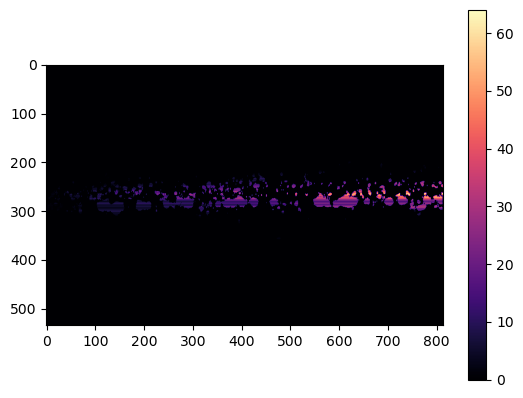

In [13]:
from skimage.measure import label, regionprops

kymos = exp1.labeled_img_array.copy()


plt.imshow(np.swapaxes(kymos,0,1)[0],cmap="magma")
plt.colorbar()
plt.show()

The next plot is a shit attempt to add the arrows instead of using quivers, but we have to run it to get the speeds for the color map in the next cell.

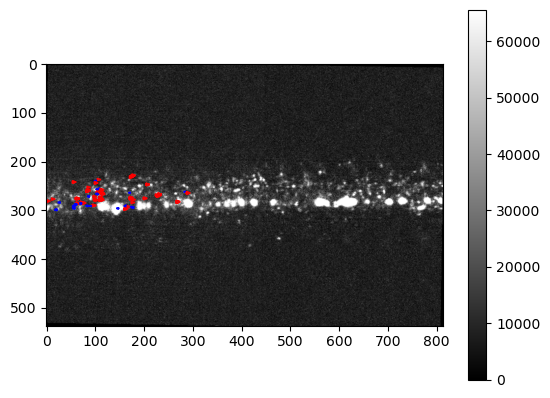

In [14]:
from skimage.measure import label, regionprops

kymos = exp1.labeled_img_array.copy()

speed_image = np.zeros_like(kymos,dtype=float)

# Assuming exp1 is an object containing image data
raw_image = exp1.images.copy()

# Create a figure and axes
fig, axs = plt.subplots()

# Display the first image from the copied images using axs.imshow()
img = axs.imshow(raw_image[0], cmap="gray")

# Add a colorbar to the plot using the mappable object (img)
cbar = plt.colorbar(img, ax=axs)
speeds = []
for id, kymo in enumerate(kymos):
    
    for region in regionprops(kymo):
        # take regions with large enough areas
        if (region.area < 100) and (region.area >= 15) and (region.eccentricity>0.9) and (np.degrees(region.orientation)>-95) and (np.degrees(region.orientation)<95) and (np.round(region.orientation,1)!= 0.0):         
            speed = (np.tan(-region.orientation))*(pixel_size/frame_time) 
            for l,c in zip(range(0,np.shape(speed_image[id])[0]),range(0,np.shape(speed_image[id])[1])):
                for coords in region.coords:
                    #print(l,c,coords[0],coords[1])
                    if l == coords[0] and c == coords[1]:
                        #print(speed)
                        if speed<30 and speed>-30:
                            speeds.append(speed)
                        # Add an arrow to the plot
                        if speed > 0:
                            axs.arrow(region.bbox[1],id,speed/10, 0,
                                    head_width=5,
                                    width=0.5,
                                    label=str(id),
                                    ec='red')
                        else:
                            axs.arrow(region.bbox[1],id,speed/10, 0,
                                    head_width=3,
                                    width=0.5,
                                    label=str(id),
                                    ec='blue')
    #print(np.max(speed_image[id]))
               
    
plt.show()             



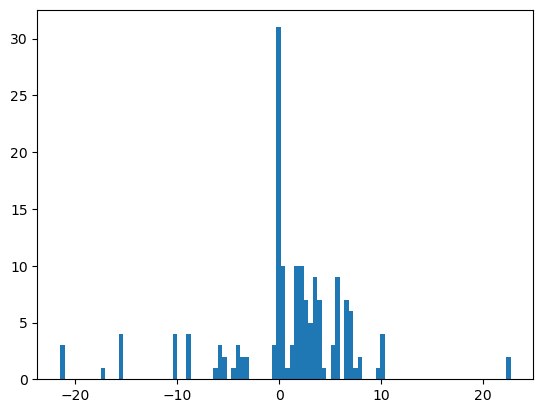

In [15]:
plt.hist(speeds,bins=100)
plt.show()

Run this cell after the previous or it will be shit. This plot is an overlay of the detected events (and their velocity color coded) over the first time point of the raw timelapse

<Figure size 7680x5760 with 0 Axes>

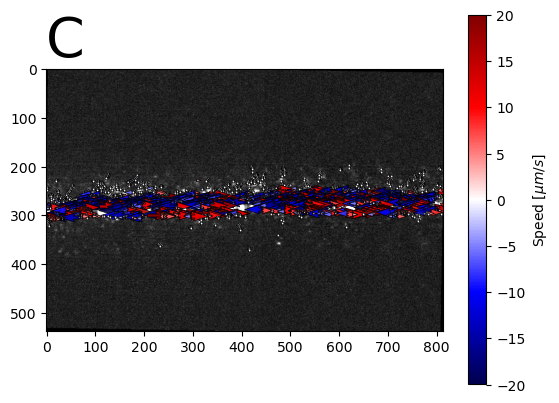

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
plt.figure(dpi=1200)
# Assuming exp1 is an object containing image data
raw_image = exp1.images.copy()
kymos = exp1.labeled_img_array.copy()

# Create a figure and axes
fig, axs = plt.subplots()

# Display the first image from the copied images using axs.imshow()
img = axs.imshow(raw_image[0], cmap="gray")

# Add a colorbar to the plot using the mappable object (img)
#cbar = plt.colorbar(img, ax=axs)

# Create a color map and a normalized scalar mappable for the arrows
cmap = plt.get_cmap('seismic')  # You can choose any colormap you prefer
norm = plt.Normalize(vmin=-20, vmax=20)
sm = plt.cm.ScalarMappable(cmap=cmap,norm = norm)

for id, kymo in enumerate(kymos):
    for region in regionprops(kymo):
        # Your existing code...
        if (region.area < 100) and (region.area >= 15) and (region.eccentricity>0.9) and (np.degrees(region.orientation)>-95) and (np.degrees(region.orientation)<95) and (np.round(region.orientation,1)!= 0.0):         
         
            # Calculate speed
            speed = -(np.tan(-region.orientation))*(pixel_size/frame_time) 
            if speed<20 and speed>-20:
                          
                # Add an arrow to the plot
                arrow_color = cmap(norm(speed))
            
                axs.quiver(region.bbox[1], id, np.sign(speed), 0,
                        angles='xy', 
                        scale_units='xy',
                        scale = abs(1/speed)/3,
                        edgecolor="black",
                        linewidth=.5,
                        color=arrow_color,
                        alpha=0.9
                        )

# Add colorbar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label(r'Speed [$\mu m / s$]')
plt.title("C",loc="left",size=40)
plt.show()
